In [2]:
# coding=UTF-8 
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
batch_size = 200
learning_rate = 1e-2
path = "/home/wuyanyan/Faces/faces_2/"

In [4]:
class FaceDataset(Dataset):
    def __init__(self, root_path, transforms = None, dataset_type = True):
        self.root_path = root_path
        self.file_paths = []
        self.labels = []
        self.transforms = transforms
        self.dataset_type = dataset_type
        label_dict = {'left': 0, 'right': 1, 'up': 2, 'straight': 3}
        for sub_dir in os.listdir(root_path):
            sub_path = root_path + sub_dir
            if os.path.isdir(sub_path):
                for file_name in os.listdir(sub_path):
                    #if file_name.endwith('pgm'):
                        self.file_paths.append(sub_path + '/' + file_name)
                        file_all_name = os.path.splitext(file_name)#将文件名与拓展名分开
                        file_seg_name = file_all_name[0]#仅取文件名label = file_name.split("_", 3)[1]
                        label = file_seg_name.split("_", 3)[1]
                        label = label_dict[label] #可以当成一个函数，就是输入的是left,输出的是0
                        self.labels.append(label)  
        if (dataset_type == True):
            self.file_paths = self.file_paths[:len(self.file_paths)*8//10]
        if (dataset_type == False):
            self.file_paths = self.file_paths[len(self.file_paths)*8//10:]
        if (dataset_type == True):
            self.labels = self.labels[:len(self.labels)*8//10]
        if (dataset_type == False):
            self.labels = self.labels[len(self.labels)*8//10:] 
            
            
    def __len__(self):
        return len(self.file_paths)
        
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]#得到第几张图片
        #print(img_path)
        image = cv2.imread(img_path)
        #print(image.shape)
        label = self.labels[idx]
        sample = [image, label]#是一个元祖tuple
        if not self.transforms is None:
            sample = self.transforms(sample)  
        return sample

In [5]:
class Resize(object):
    def __init__(self, output_size):
        self.output_size = output_size
    def __call__(self, sample):
        sample[0] = cv2.resize(sample[0], self.output_size)
        return sample
    
class ToTensor(object):
    def __init__(self):
        pass
    def __call__(self, sample):
        sample[0] = torch.tensor(np.transpose(sample[0],(2, 0, 1)),dtype = torch.float32)#h（0）w（1）c（2）是012，这里要变成chw（所以是201）
        sample[1] = torch.tensor(sample[1],dtype = torch.int64)
        return (sample[0], sample[1])

In [6]:
face_dataset_train = FaceDataset(root_path = path,
                           transforms = torchvision.transforms.Compose([
                               Resize((224, 224)),
                               ToTensor()]),dataset_type = True)

face_dataset_test = FaceDataset(root_path = path,
                           transforms = torchvision.transforms.Compose([
                               Resize((224, 224)),
                               ToTensor()]),dataset_type = False)

face_loader_train = DataLoader(dataset = face_dataset_train, 
                          batch_size = batch_size, 
                          shuffle = True)#,   #把数据打乱 
                          #num_workers = 4)   #多线程读图片，即用了4个线程
    
face_loader_test = DataLoader(dataset = face_dataset_test, 
                          batch_size = batch_size, 
                          shuffle = True)#,   #把数据打乱 
                          #num_workers = 4)   #多线程读图片，即用了4个线程

In [7]:
class ResNet(nn.Module):
    def __init__(self, model):
        super(ResNet, self).__init__()
        self.resnet_layer = nn.Sequential(*list(model.children())[:-1])#去掉预训练resnet模型的后1层(fc层)
        self.Linear_layer = nn.Linear(2048, 4)#分类层

    def forward(self, x):
        x = self.resnet_layer(x)
        x = x.view(x.size(0), -1) 
        x = self.Linear_layer(x)
        return x


In [8]:
resnet = models.resnet50(pretrained=True)
model1 = ResNet(resnet)
model = nn.DataParallel(model1, device_ids = [0, 1, 2, 3]).cuda()
criterion = nn.CrossEntropyLoss()
#定义优化器
#调整优化器参数选择最优
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate, weight_decay = 1e-6, momentum = 0.9)

In [9]:
for epoch in range(10):
    for data in face_loader_train:
        batch_x = data[0].cuda()   #从loader这个迭代器中取出图片
        batch_y = data[1].cuda()   #从loader这个迭代器中取出label
        optimizer.zero_grad()  #优化器梯度初始化为零
        output = model(batch_x)   #把数据输入网络并得到输出，即进行前向传播
        loss = criterion(output, batch_y) #计算损失函数
        loss.backward()        #反向传播梯度
        optimizer.step()       #结束一次前传+反传之后，更新优化器参数

In [10]:
torch.save(model1.state_dict(), 'resnet50_face.pt')#第二个参数是我为这个模型命名，官方后缀为pt或pth，但是瞎写成别的也能用，例如pkl,ks等
                                    #我保存的是一个网络，也包含我所修改的fc层

In [11]:
#定义函数计算准确率
def get_correct_num(pred, target):
    correct = pred.eq(target.data.view_as(pred)).cpu().sum()  # 对预测正确的数据个数进行累加 
    return correct

def get_acc_on_dataset(model, dataset):
    correct = 0
    for data in dataset:
        batch_x = data[0].cuda()
        batch_y = data[1].cuda()
        output = model(batch_x)
        correct += get_correct_num(output.argmax(dim=1),batch_y)
        
    return (correct.type(torch.float32))

In [12]:
train_correct = get_acc_on_dataset(model, face_loader_train)
print(train_correct/len(face_dataset_train))
test_correct = get_acc_on_dataset(model, face_loader_test)
print(test_correct/len(face_dataset_test))

tensor(0.9993)
tensor(0.9709)


In [13]:
class FaceAPI(object):
    def __init__(self, model_path):
        self.model = model1#加载一下之前训练好的
        self.model.load_state_dict(torch.load(model_path))
        self.model.eval()#只能预测，不能训练，所以要加这一句evaluate的简写，不然的话，如果里面有dropout,那么预测的时候也会有dropout，我们不希望这样
                        #这是别人定义好的函数，resnet本身就有这函数，调用一下这个，它就知道时候预测了，不是训练了，那么它里面的dropout什么的就不会起作用了，
        self.label_dict = {0: 'left', 1: 'right', 2: 'up', 3: 'straight'}
        
    #定义函数的先后顺序没有要求，因为定义的时候还没有调用
    def predict(self, image):#预测
        image = self._preprocess(image).cuda()
        output = self.model(image).argmax(dim =1).cpu().numpy()[0]
        return self.label_dict[output], np.transpose(image.cpu().numpy()[0],(1,2,0))#第二个返回值是为了确认一下，是否变为灰度图了
    
    def _preprocess(self, image):#处理图片
        image = cv2.cvtColor(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)
        image = cv2.resize(image, (224,224))
        image = torch.tensor(np.transpose(image, (2, 0, 1)),dtype = torch.float32).view(1, 3, 224, 224)
        return image

In [14]:
tmp = FaceAPI("/home/wuyanyan/Faces/resnet50_face.pt")

In [19]:
img = cv2.imread("/home/wuyanyan/Faces/qin2.jpg")

In [20]:
result, img = tmp.predict(img)

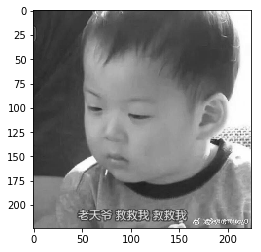

In [21]:
plt.imshow(img/255)

In [22]:
result

'right'